In [6]:
from typing import Optional, List, Dict
import os
import time
if "hh_combination_fw_path" not in os.environ:
    os.environ['hh_combination_fw_path'] = os.path.abspath("../../")

In [53]:
config = {
    'inputdir': '/eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/PUBHEFT2022/20220301_HEFT_newCDI',
    # change your output directory here
    'outdir': os.path.join(os.environ['hh_combination_fw_path'], 'outputs_newCDI'),
    'scenarios': ['SM'] + [f'BM{i}' for i in range(1, 7 + 1)],
    'channels': ['bbyy', 'bbtautau'],
    'resonant_type': 'nonres',
    'file_expr': '<mass[F]>',
    'correlation_scheme': 'HEFT_nonres_v2.json',
    'task_option': 'HEFT_nonres_v1.yaml',
    'parallel': -1,
    'ranking': ['BM3', 'BM5'],
    'ranking_exclude': 'gamma_*,nbkg_*,ATLAS_norm_*,BKG_*',
}

In [8]:
def construct_commands(config:Dict):
    channels = ','.join(config['channels'])
    hhcomb_path = os.environ.get('hh_combination_fw_path', None)
    if hhcomb_path is None:
        raise RuntimeError("hh combination framework is not set up properly, please run setup.sh first")
    task_option_path = os.path.join(hhcomb_path, "configs", "task_options", config['task_option'])
    correlation_scheme_path = os.path.join(hhcomb_path, "configs", "correlation_schemes", config['correlation_scheme'])
    if not os.path.exists(task_option_path):
        raise FileNotFoundError(f"file \"{task_option_path}\" does not exist")
    if not os.path.exists(correlation_scheme_path):
        raise FileNotFoundError(f"file \"{correlation_scheme_path}\" does not exist")
    file_expr = config['file_expr']
    commands = {'process_channels': [], 'combine_ws': []}
    for scenario in config['scenarios']:
        input_path = os.path.join(config['inputdir'], scenario)
        output_path = os.path.join(config['outdir'], scenario)
        # process channels
        command_channel = f"HHComb process_channels -i {input_path} -c \"{channels}\" -r {config['resonant_type']} " +\
                          f"-o {output_path} --file_expr \"{file_expr}\" --config {task_option_path} " +\
                          f"--parallel {config['parallel']} --unblind"
        commands['process_channels'].append(command_channel)
        # combination
        command_comb = f"HHComb combine_ws -i {output_path} -s {correlation_scheme_path} -c \"{channels}\" " +\
                       f"-r {config['resonant_type']} --file_expr \"{file_expr}\" --config {task_option_path} " +\
                       f"--parallel {config['parallel']} --unblind"
        commands['combine_ws'].append(command_comb)
    for command_type in commands:
        # parallelization
        commands[command_type] = ' & '.join(commands[command_type])
    return commands

In [9]:
commands = construct_commands(config)

In [10]:
print("# commands for processing individual channels")
print()
print(commands['process_channels'])
print()
print("# commands for combination")
print()
print(commands['combine_ws'])

# commands for processing individual channels

HHComb process_channels -i /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/PUBHEFT2022/20220301_HEFT_newCDI/SM -c "bbyy,bbtautau" -r nonres -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM --file_expr "<mass[F]>" --config /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/configs/task_options/HEFT_nonres_v1.yaml --parallel -1 --unblind & HHComb process_channels -i /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/PUBHEFT2022/20220301_HEFT_newCDI/BM1 -c "bbyy,bbtautau" -r nonres -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM1 --file_expr "<mass[F]>" --config /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/configs/task_options/HEFT_nonres_v1.yaml --parallel -1 --unblind & HHComb process_channels -i /eos/atlas/atlascerngroupdisk/phys-hdbs/di

In [13]:
!{commands['process_channels']}


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.t

INFO: Regularising /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/20220204_HEFT/BM1/bbtautau/nonres/0.root --> /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/HEFT/outputs_BM_study_unblind_24_02_2022/BM1/regularised/nonres/bbtautau/0.root
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/submodules/workspaceCombiner/bin/manager -w decorate -f /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/20220204_HEFT/BM1/bbtautau/nonres/0.root -p /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/HEFT/outputs_BM_study_unblind_24_02_2022/BM1/regularised/nonres/bbtautau/0.root -d obsData
INFO: Writing regularisation log into /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/HEFT/outputs_BM_study_unblind_24_02_2022/BM1/regularised/nonres/bbtautau/0.log
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/submodules/workspaceCo

INFO: Regularising /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/20220204_HEFT/SM/bbyy/nonres/0.root --> /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/HEFT/outputs_BM_study_unblind_24_02_2022/SM/regularised/nonres/bbyy/0.root
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/submodules/workspaceCombiner/bin/manager -w decorate -f /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/20220204_HEFT/SM/bbyy/nonres/0.root -p /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/HEFT/outputs_BM_study_unblind_24_02_2022/SM/regularised/nonres/bbyy/0.root -d combData
Skip: regularisation output /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/HEFT/outputs_BM_study_unblind_24_02_2022/SM/regularised/nonres/bbyy/0.root exists, skip regularisation
INFO: Creating config file: /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw

In [14]:
!{commands['combine_ws']}




RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 

                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                All rights reserved, please read http://roofit.sourceforge.net/license.txt
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University

                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                All rights reserved, please read http://roofit.sourceforge.net/license.txt
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University

                All rights reserved, please read http://roofit.sourceforge.net/license.t

INFO: Task finished. Total time taken: 1.042 s


## Plot limit results

In [11]:
from quickstats.plots import UpperLimitBenchmarkPlot
from quickstats.utils.common_utils import combine_dict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
limit_data = {}
for channel in config['channels'] + ['combined']:
    limit_data[channel] = {}
    for scenario in config['scenarios']:
        outdir = os.path.join(config['outdir'], scenario, 'limits', config['resonant_type'], channel)
        if channel != 'combined':
            limit_path = os.path.join(outdir, "limits.json")
        else:
            limit_path = os.path.join(outdir, "A-{}-fullcorr".format("_".join(sorted(config['channels']))), "limits.json")
        if not os.path.exists(limit_path):
            raise FileNotFoundError(f"file \"{limit_path}\" not found")
        limit_data[channel][scenario] = {k:v[0] for k,v in json.load(open(limit_path)).items()}
    limit_data[channel] = pd.DataFrame(limit_data[channel]).transpose()

In [9]:
limit_data['combined']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.089020,0.178673,0.126830,0.064144,0.047780,0.088125,0.0
BM1,0.0,0.129710,0.262299,0.185318,0.093464,0.069619,0.134813,0.0
BM2,0.0,0.134605,0.271111,0.192011,0.096991,0.072246,0.134783,0.0
BM3,0.0,0.056753,0.119800,0.082290,0.040894,0.030461,0.062756,0.0
BM4,0.0,0.065399,0.131139,0.093185,0.047124,0.035101,0.069087,0.0
BM5,0.0,0.054199,0.111379,0.077850,0.039053,0.029090,0.058348,0.0
BM6,0.0,0.086273,0.172985,0.122901,0.062164,0.046305,0.089057,0.0
BM7,0.0,0.045878,0.092566,0.065525,0.033058,0.024624,0.050331,0.0


In [13]:
limit_data['combined']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.089020,0.178672,0.126831,0.064144,0.047779,0.088125,0.0
BM1,0.0,0.130076,0.264446,0.186179,0.093727,0.069815,0.135023,0.0
BM2,0.0,0.134902,0.272922,0.192716,0.097205,0.072406,0.134935,0.0
BM3,0.0,0.056902,0.120748,0.082647,0.041001,0.030541,0.062865,0.0
BM4,0.0,0.065520,0.131943,0.093485,0.047211,0.035167,0.069157,0.0
BM5,0.0,0.054314,0.112095,0.078122,0.039136,0.029151,0.058416,0.0
BM6,0.0,0.086432,0.174031,0.123291,0.062279,0.046390,0.089146,0.0
BM7,0.0,0.045983,0.093180,0.065754,0.033133,0.024680,0.050389,0.0


In [5]:
limit_data['bbyy']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.171222,0.379666,0.253113,0.123375,0.091899,0.127700,0.0
BM1,0.0,0.292286,0.630573,0.428016,0.210608,0.156877,0.189232,0.0
BM2,0.0,0.266603,0.580714,0.391620,0.192102,0.143093,0.182984,0.0
BM3,0.0,0.162769,0.365492,0.241652,0.117284,0.087362,0.109703,0.0
BM4,0.0,0.155404,0.346426,0.230125,0.111977,0.083409,0.111165,0.0
BM5,0.0,0.137545,0.308707,0.204128,0.099109,0.073824,0.097866,0.0
BM6,0.0,0.188601,0.418513,0.278912,0.135898,0.101227,0.134407,0.0
BM7,0.0,0.125969,0.282098,0.186804,0.090768,0.067611,0.088828,0.0


In [6]:
limit_data['bbtautau']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.108757,0.218531,0.155066,0.078366,0.058373,0.128198,0.0
BM1,0.0,0.148557,0.307472,0.213997,0.107044,0.079734,0.193217,0.0
BM2,0.0,0.161797,0.331189,0.232190,0.116584,0.086841,0.199791,0.0
BM3,0.0,0.061997,0.133849,0.090720,0.044673,0.033276,0.082125,0.0
BM4,0.0,0.074618,0.151183,0.106754,0.053766,0.040049,0.093310,0.0
BM5,0.0,0.060842,0.127198,0.087907,0.043840,0.032655,0.077635,0.0
BM6,0.0,0.100606,0.203652,0.143859,0.072493,0.053998,0.124165,0.0
BM7,0.0,0.050617,0.103298,0.072599,0.036472,0.027167,0.065253,0.0


In [7]:
limit_data['combined']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.088149,0.176753,0.125584,0.063517,0.047312,0.086830,0.0
BM1,0.0,0.128604,0.260998,0.183997,0.092666,0.069025,0.134037,0.0
BM2,0.0,0.133545,0.269903,0.190756,0.096226,0.071677,0.133587,0.0
BM3,0.0,0.056163,0.118825,0.081505,0.040469,0.030144,0.062550,0.0
BM4,0.0,0.064895,0.130526,0.092577,0.046760,0.034831,0.068577,0.0
BM5,0.0,0.053716,0.110651,0.077229,0.038705,0.028831,0.058046,0.0
BM6,0.0,0.085543,0.172059,0.122014,0.061639,0.045913,0.088284,0.0
BM7,0.0,0.045475,0.091944,0.065002,0.032767,0.024407,0.050248,0.0


In [14]:
for channel in limit_data:
    output_path = os.path.join(config['outdir'], f"BM_limits_{channel}.json")
    json.dump(limit_data[channel].to_dict('index'), open(output_path, "w"), indent=2)

In [15]:
label_map = {
    'SM': 'SM',
    'BM1': '1',
    'BM2': '2',
    'BM3': '3',
    'BM4': '4',
    'BM5': '5',
    'BM6': '6',
    'BM7': '7'
}
analysis_label_options = {
    'energy': '13 TeV',
    'lumi': '139 fb$^{-1}$',
    'fontsize': 30
}
channel_text = {
    'bbtautau': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-}$',
    'bbyy': r'$\mathrm{HH\rightarrow b\bar{b}\gamma\gamma}$',
    'combined': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-} + b\bar{b}\gamma\gamma$'
}
styles = {
    'legend':{
        'loc': (0.5, 0.58)
    }
}
plot_config = {
    'markersize': 60
}
ylim = {
    'bbyy': (18, 6000),
    'bbtautau': (18, 3000),
    'combined': (18, 2000),
}

In [16]:
def plot_benchmark_limit(all_data, channel:str, save_as:Optional[str]=None):
    data = all_data[channel]
    label_options = {**analysis_label_options, 'extra_text': channel_text[channel]}
    plotter = UpperLimitBenchmarkPlot(data, label_map, limit_scale=1000,
                                  styles=styles, config=plot_config,
                                  analysis_label_options=label_options)
#     plotter.add_hline(y=31.05, color='#F2385A', label=r'$\sigma^{\mathrm{SM}}_{\mathrm{ggF\, HH}}$')
    plotter.draw(ylabel="$\sigma_{\mathrm{ggF}}$ (HH) [fb]", xlabel="Shape benchmark",
                 logy=True, ylim=ylim[channel])
    if save_as is not None:
        plt.savefig(save_as, bbox_inches="tight")

In [17]:
plot_outdir = os.path.join(config['outdir'], 'plots')
if not os.path.exists(plot_outdir):
    os.makedirs(plot_outdir)

<Figure size 432x288 with 0 Axes>

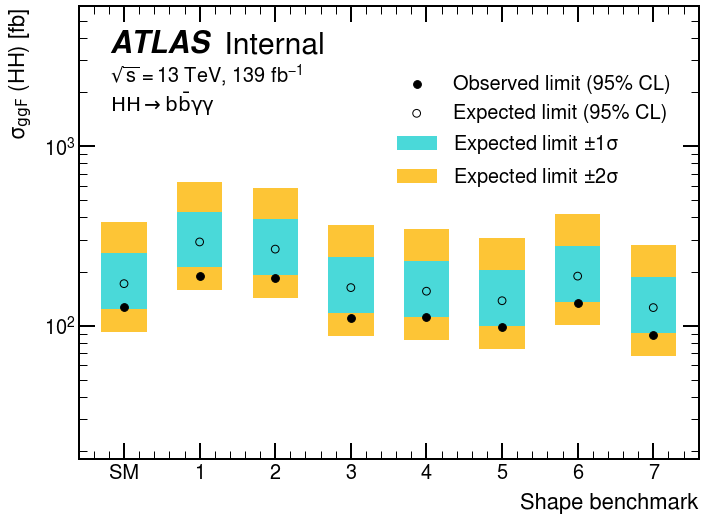

<Figure size 432x288 with 0 Axes>

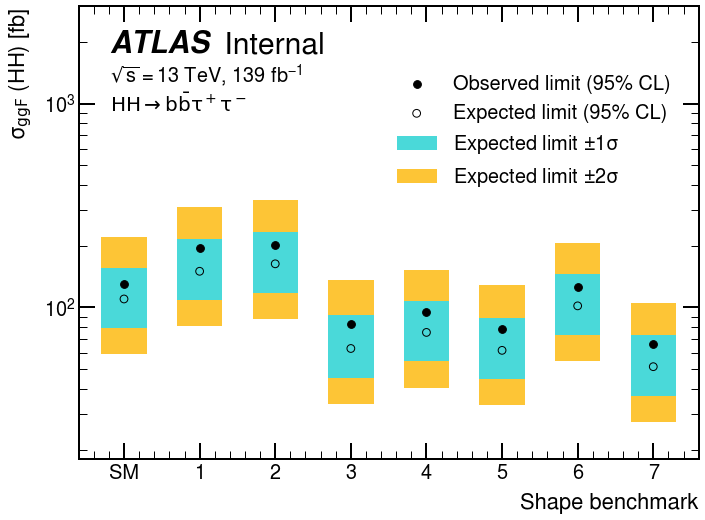

<Figure size 432x288 with 0 Axes>

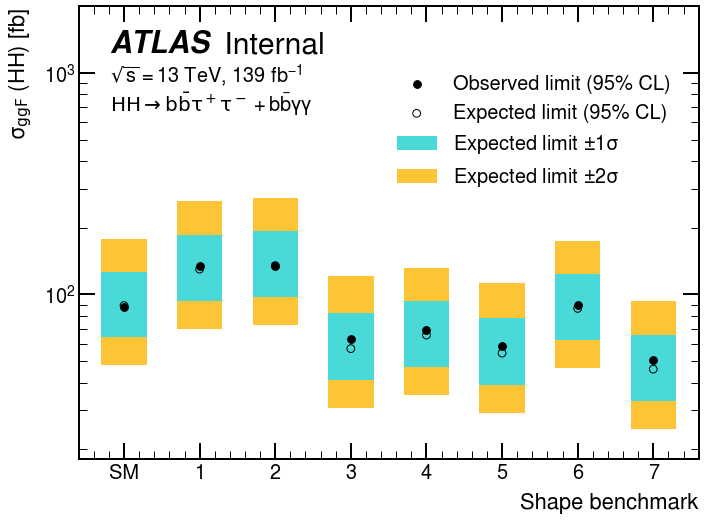

In [18]:
for channel in limit_data:
    save_path = os.path.join(plot_outdir, f'{channel}_benchmark_limit.pdf')
    plot_benchmark_limit(limit_data, channel, save_as=save_path)
    plt.show()

## Ranking

In [54]:
def construct_ranking(config:Dict):
    inputs = ['combined/nonres/A-bbtautau_bbyy-fullcorr/0.root', 'rescaled/nonres/bbyy/0.root', 'rescaled/nonres/bbtautau/0.root']
    outputs = ['combined', 'bbyy', 'bbtautau']
    hhcomb_path = os.environ.get('hh_combination_fw_path', None)
    if hhcomb_path is None:
        raise RuntimeError("hh combination framework is not set up properly, please run setup.sh first")
    task_option_path = os.path.join(hhcomb_path, "configs", "task_options", config['task_option'])
    correlation_scheme_path = os.path.join(hhcomb_path, "configs", "correlation_schemes", config['correlation_scheme'])
    if not os.path.exists(task_option_path):
        raise FileNotFoundError(f"file \"{task_option_path}\" does not exist")
    if not os.path.exists(correlation_scheme_path):
        raise FileNotFoundError(f"file \"{correlation_scheme_path}\" does not exist")
    file_expr = config['file_expr']
    commands = {'ranking': []}
    for scenario in config['ranking']:
        output_path = os.path.join(config['outdir'], scenario)
        # process channels
        for ws, out in zip(inputs, outputs):
            command_channel = f"quickstats run_pulls --batch_mode --poi xsec_br " +\
                            f" --parallel {config['parallel']} --exclude {config['ranking_exclude']} " +\
                            f" -i {output_path}/{ws} -o {output_path}/ranking/{out}"
            commands['ranking'].append(command_channel)
    return commands

In [55]:
commands = construct_ranking(config)

In [56]:
print("# commands for ranking channels")
print()
for command in commands['ranking']:
    print(command+'\n')

# commands for ranking channels

quickstats run_pulls --batch_mode --poi xsec_br  --parallel -1 --exclude gamma_*,nbkg_*,ATLAS_norm_*,BKG_*  -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM3/combined/nonres/A-bbtautau_bbyy-fullcorr/0.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM3/ranking/combined

quickstats run_pulls --batch_mode --poi xsec_br  --parallel -1 --exclude gamma_*,nbkg_*,ATLAS_norm_*,BKG_*  -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM3/rescaled/nonres/bbyy/0.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM3/ranking/bbyy

quickstats run_pulls --batch_mode --poi xsec_br  --parallel -1 --exclude gamma_*,nbkg_*,ATLAS_norm_*,BKG_*  -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM3/rescaled/nonres/bbtautau/0.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_com